# Predicting Sentiment Analysis for SXSW Tweets

#### Amelia Dahm and Eric Roberts

## Overview <a id="Overview"></a>


-------------------- INSERT PARAGRAPH HERE --------------------

[1. Business Problem](#Business-Problem)

[2. Data Understanding and Preparation](#Data-Understanding)

[3. EDA](#EDA)

[4. Modeling](#Modeling)

[5. Evaluation](#Evaluation)

[6. Conclusion](#Conclusion)


***

## Business Problem <a id="Business-Problem"></a>
##### [(back to top)](#Overview)

-------------------- INSERT PARAGRAPH HERE --------------------


- from the perspective of festival organizers
- 280 thousand attendees //// 360 million economic impact in Austin, TX
- flag the negative tweets to address concerns
- how to keep festival relevant/thriving

***

## Data Understanding and Preperation <a id="Data-Understanding"></a>
##### [(back to top)](#Overview)

This data source is entitled 'Brands and Produt Emotions' from [data.world](https://data.world/crowdflower/brands-and-product-emotions). The dataset has 9093 records that include tweets with an assigned product and emotion. 




In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from sklearn.utils import resample
import string, re
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from sklearn.metrics import plot_confusion_matrix

In [2]:
# do we want to add cleaning steps here or link to noteboook with it aall

#import dataset
df = pd.read_csv('data/dataframe.csv', index_col=0)
df.head()

,tweet,product_,emotion,lemmatizer_tweets,textblob_polarity,textblob_subjectivity,vs_neg,vs_neu,vs_pos,vs_compound,nrc_sentiment,gi_sentiment,henry_sentiment,huliu_sentiment,jockers_sentiment,lm_sentiment,senticnet_sentiment,sentiword_sentiment,socal_sentiment
0,"['wesley83', 'have', '3G', 'iPhone', '3', 'hrs...",iPhone,0,wesley83 have 3G iPhone 3 hr tweeting RISE Aus...,-0.200000,0.400000,0.223,0.777,0.000,-0.6486,0.0,-0.333333,0.0,-1.0,-1.000000,0.0,-0.09520,-0.221875,-1.192154
1,"['jessedee', 'Know', 'fludapp', 'Awesome', 'iP...",iPad or iPhone App,1,jessedee Know fludapp Awesome iPad iPhone app ...,0.466667,0.933333,0.000,0.528,0.472,0.9100,1.0,1.000000,0.0,1.0,0.416667,0.0,0.47500,0.175000,2.177190
2,"['swonderlin', 'not', 'wait', 'iPad', '2', 'al...",iPad,1,swonderlin not wait iPad 2 also should sale do...,-0.155556,0.288889,0.000,1.000,0.000,0.0000,-1.0,-1.000000,-1.0,-1.0,-0.625000,-1.0,-0.30550,-0.289062,-1.000000
3,"['sxsw', 'hope', 'year', 'festival', 't', 'cra...",iPad or iPhone App,0,sxsw hope year festival t crashy this year iPh...,0.000000,0.000000,0.000,0.596,0.404,0.7269,1.0,1.000000,0.0,0.0,0.500000,0.0,0.07160,0.250000,2.841547
4,"['sxtxstate', 'great', 'stuff', 'Fri', 'SXSW',...",Google,1,sxtxstate great stuff Fri SXSW Marissa Mayer G...,0.800000,0.750000,0.000,0.796,0.204,0.6249,0.0,1.000000,0.0,1.0,0.500000,1.0,0.55125,0.083333,1.554026


In [3]:
df.emotion.value_counts()

3    5388
1    2978
0     570
4     156
Name: emotion, dtype: int64

In [4]:
df.dtypes

tweet                     object
product_                  object
emotion                    int64
lemmatizer_tweets         object
textblob_polarity        float64
textblob_subjectivity    float64
vs_neg                   float64
vs_neu                   float64
vs_pos                   float64
vs_compound              float64
nrc_sentiment            float64
gi_sentiment             float64
henry_sentiment          float64
huliu_sentiment          float64
jockers_sentiment        float64
lm_sentiment             float64
senticnet_sentiment      float64
sentiword_sentiment      float64
socal_sentiment          float64
dtype: object

***

## EDA <a id="EDA"></a>
##### [(back to top)](#Overview)

-------------------- INSERT PARAGRAPH HERE --------------------

- textblob vander sent
- tfidf
- distribution of tweets by product/company
- word frequencies by valence and product

In [5]:
# WORD CLOUDS woooo

***

## Modeling <a id="Modeling"></a>
##### [(back to top)](#Overview)


The goal of this project was to classify tweets into sentiment categories: positive, negative, neutral, and unclear.  For classying the tweets into these categories, we tested random forest models and neural networks. Before fitting the data to the models, we lemmatized the tweets, removed stop words, and used a tfidf vectorizer. This process was iterative. 

In [6]:
## setting stopwords and punctuations
stop_words=stopwords.words("english")
stop_words += list(string.punctuation)
stop_words += ['...','u','w','2',"i'm",'via',"we're",'6','3','hey']
# print(stop_words)
sw_set = set(stop_words)

In [7]:
neg = df[df.emotion==0]
pos = df[df.emotion==1]
idk = df[df.emotion==4]
neu = df[df.emotion==3]

In [8]:
# upsample negative
neg_upsampled = resample(neg,
                          replace=True, # sample with replacement
                          n_samples=len(neu), # match number in majority class
                          random_state=23) # reproducible results

# upsample positive
pos_upsampled = resample(pos,
                          replace=True, # sample with replacement
                          n_samples=len(neu), # match number in majority class
                          random_state=23) # reproducible results

# upsample unclear
idk_upsampled = resample(idk,
                          replace=True, # sample with replacement
                          n_samples=len(neu), # match number in majority class
                          random_state=23) # reproducible results

upsampled = pd.concat([neu, neg_upsampled, pos_upsampled, idk_upsampled])

In [9]:
# creating a list with all lemmatized outputs
data = upsampled['lemmatizer_tweets']
lemmatized_output = []

for listy in data:
    lemmed = ''.join([w for w in listy])
    lemmatized_output.append(lemmed)

In [10]:
# define x and y
X_lem = lemmatized_output
y_lem = upsampled['emotion']

In [11]:
# train test split the lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)

# fit and transform
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

In [12]:
# Average number of non-zero elements in vectorized tweets
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print(non_zero_cols)

# Percentage of columns containing zero
percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print(percent_sparse)

22.46952032944725
0.9994795107637376


#### Random Forest

In [13]:
# Create, fit, and predict on data

# Instatiate classifier
rf_lem = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# fit model to lemmatized tfidf data
rf_lem.fit(tfidf_data_train_lem, y_train_lem)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [14]:
rf_train_preds_lem = rf_lem.predict(tfidf_data_train_lem)
metrics.accuracy_score(y_train_lem, rf_train_preds_lem)

0.9979119540629894

In [15]:
# predict on test set
rf_test_preds_lem = rf_lem.predict(tfidf_data_test_lem)

# get metrics
rf_acc_score_lem = metrics.accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = metrics.f1_score(y_test_lem, rf_test_preds_lem, average='weighted')
rf_precision_score_lem = metrics.precision_score(y_test_lem, rf_test_preds_lem, average='weighted')
rf_recall_score_lem = metrics.recall_score(y_test_lem, rf_test_preds_lem, average='weighted')
print('Accuracy:', rf_acc_score_lem)
print('Precision:',rf_precision_score_lem)
print('Recall:',rf_recall_score_lem)
print('F1:',rf_f1_score_lem)

Accuracy: 0.9220598469032707
Precision: 0.9210386351303297
Recall: 0.9220598469032707
F1: 0.9212052860626472


#### Grid Search

In [16]:
# # Instatiate classifier
# rfc=RandomForestClassifier(random_state=42)

# # what parameters to test
# param_grid = { 
#     'n_estimators': list(range(130,140)),
#     'max_features': ['auto'],
#     'max_depth' : list(range(18,20)),
#     'criterion' : ['gini']}

# # search and fit model
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(tfidf_data_train_lem, y_train_lem)

# # # print metrics
# print('Best Score:', CV_rfc.best_score_)
# print('Best Parameters:',CV_rfc.best_params_)
# print('Best Estimator:',CV_rfc.best_estimator_)

In [17]:
# pulled the parameters from the grid search .best_params_
rfc=RandomForestClassifier(max_depth=19, n_estimators=130, random_state=42, criterion='gini', max_features='auto')

In [18]:
# fit the model
rfc.fit(tfidf_data_train_lem, y_train_lem)

RandomForestClassifier(max_depth=19, n_estimators=130, random_state=42)

In [19]:
# predict on test set
rf_test_preds_lem1 = rfc.predict(tfidf_data_test_lem)

In [20]:
# get metrics
rf_acc_score_lem1 = metrics.accuracy_score(y_test_lem, rf_test_preds_lem1)
rf_f1_score_lem1 = metrics.f1_score(y_test_lem, rf_test_preds_lem1, average='weighted')
rf_precision_score_lem1 = metrics.precision_score(y_test_lem, rf_test_preds_lem1, average='weighted')
rf_recall_score_lem1 = metrics.recall_score(y_test_lem, rf_test_preds_lem1, average='weighted')
print('Accuracy:', rf_acc_score_lem1)
print('Precision:',rf_precision_score_lem1)
print('Recall:',rf_recall_score_lem1)
print('F1:',rf_f1_score_lem1)

Accuracy: 0.7531895151936906
Precision: 0.7518645665718574
Recall: 0.7531895151936906
F1: 0.749382720827409


#### Neural Network

In [21]:
# update outcome category
df['emotion'] = np.where(df['emotion'] == 4, 2, df['emotion'])

In [22]:
# grab numerical features
data = df.drop(columns=['emotion', 'tweet', 'product_', 'lemmatizer_tweets'])
target = df['emotion']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=1)
# Look at shape for inputs
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7273, 15)
(1819, 15)
(7273,)
(1819,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=1)

# tomek links for class imbalance
tl = TomekLinks()
X_train, y_train = tl.fit_resample(X_train, y_train)

# how many folds to separate data
batch_size = 8
# how many classes in outcomes
num_classes = 4
epochs = 15

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# specifying the model structure
model = Sequential()

# specify the first hidden layer
model.add(Dense(100, activation='relu', input_shape=(15,)))
model.add(Dropout(0.2))

# specify the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# specify the third layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# specify the output layer
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1600      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4

In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8971265554428101
Test accuracy: 0.6179219484329224


***

## Evaluation <a id="Evaluation"></a>
##### [(back to top)](#Overview)

This process was iterative. To evaluate our models, we used accuracy scores. The final iteration of our best model was the random forest model using grid search that gave us a 0.6728 accuracy.  

#### Model Metrics

In [26]:
print('Model Metrics:')
print(' - Accuracy:', rf_acc_score_lem)
print(' - Precision:',rf_precision_score_lem)
print(' - Recall:',rf_recall_score_lem)
print(' - F1:',rf_f1_score_lem)

Model Metrics:
 - Accuracy: 0.9220598469032707
 - Precision: 0.9210386351303297
 - Recall: 0.9220598469032707
 - F1: 0.9212052860626472


#### Confusion Matrix

Confusion matrix, without normalization
[[1097    0    0    0]
 [   4  911  130    0]
 [  27  160  872   15]
 [   0    0    0 1095]]
Normalized confusion matrix
[[1.         0.         0.         0.        ]
 [0.00382775 0.87177033 0.12440191 0.        ]
 [0.02513966 0.14897579 0.81191806 0.01396648]
 [0.         0.         0.         1.        ]]


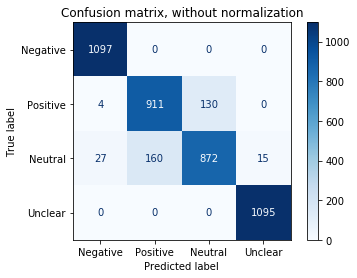

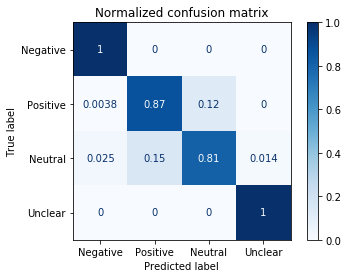

In [28]:
class_names = ['Negative', 'Positive', 'Neutral', 'Unclear']

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf_lem, tfidf_data_test_lem, y_test_lem,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('./images/rfc_confusion_matrix.png')    
plt.show()

***

## Conclusion <a id="Conclusion"></a>
##### [(back to top)](#Overview)

-------------------- INSERT PARAGRAPH HERE --------------------

- everything summed up



- explain why accuracy is low (how to use and not use)